In [1]:
%matplotlib inline
import numpy as np
#from autograd import numpy as np
import bayesian_pdes as bpdes
from scipy import stats, linalg
import matplotlib.pyplot as plt
import mcmc
import sympy as sp
import os
import time
import eit
import time
%load_ext mcmc
%mcmc notebook

In [2]:
from IPython.core.magic import register_cell_magic, needs_local_scope
@needs_local_scope
@register_cell_magic
def capture_cell(line, cell):
    globals()[line.strip()] = cell
    exec(cell, globals())

In [3]:
use_dummy_data = False
dummy_data_file = os.path.join('dummy_data', 'centered_blob')

In [4]:
%%capture_cell params
scale = 1000
stim_current = 1.0

kernel_variance_mult = 100.0
kernel_ls = 0.3007
kernel_ls = 0.238
conductivity_variance_mult = 1.0 # 1e-3 is good
conductivity_ls = 0.3
run_time = 8

likelihood_variance = 1.0 # variance for the observation model - based on the value from RA paper

n_radii_forward = 10
n_radii_inverse = 8
bayesian = True
adapt_ls = False

include_prior_mean = False

n_repeats = 10000
n_iter = 100
thin = 100
restart = False

In [5]:
dest_dir = os.path.join('results', 'static_recovery_f{}_n={}'.format(run_time, n_radii_forward))
if not bayesian:
    dest_dir += '_collocation'
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

In [6]:
with open(os.path.join(dest_dir, 'params.py'), 'w') as f:
    f.write(params)

In [7]:
min_accept = 0.1
max_accept = 0.4

In [8]:
baseline = np.loadtxt('recovered_rhos.csv', delimiter=',')
baseline_xy = baseline[:,:2]
baseline_fields = baseline[:,2:]

# Sheet Parameters

In [9]:
# important helpers!
def plot_circle(x, y, values, cmap=None):
    plt.tricontourf(x.ravel(), y.ravel(), values.ravel(), cmap=cmap)
    plt.colorbar()
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

In [10]:
# code for setting up the stim pattern
stim_pattern = np.zeros((7,8))
for i in range(7):
    stim_pattern[i,0] = 1
    stim_pattern[i, i+1] = -1
stim_pattern = scale*stim_pattern*stim_current

In [11]:
meas_pattern = np.zeros((7,8))
meas_pattern[:,0] = 1
meas_pattern[:, 1:] = np.diag(-np.ones(7))

In [12]:
pattern = eit.grids.EITPattern(meas_pattern, stim_pattern)

# Load Data

In [13]:
data_file = '../data/ST1trial3.DAT'
raw_data = np.loadtxt(data_file)

In [14]:
raw_data.shape

(49, 50)

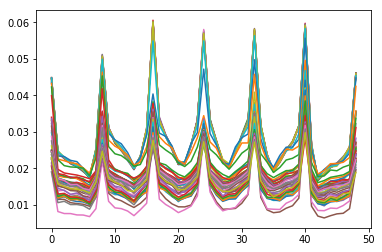

In [15]:
plt.plot(raw_data[:,1:].T);

In [16]:
raw_data.shape

(49, 50)

The data file format is as follows:
* Each row corresponds to a time
* The first element of the row gives the time index of the measurement
* The remaining columns give the measurements for each time
* These are divided into seven blocks.
    - Call the block $i$
    - Within the block the measurements correspond to electrodes $j=1,\dots,8$, $j\neq i$
    - Pair $(i,j)$ represents passing a current between electrode $i$ and electrode $j$ and measuring the voltage.
    - The voltage is measured between the _reference_ electrode at $1$ and the electrode located at $1+i$

_Is there not one too many electrodes here? This implies at some point we measure the voltage between 1 and 2 based on a current driven between 1 and 2._

_Is there a linear independence problem here? I still think there might be._

In [17]:
def data_to_dict(data):
    res = {}
    for r in data:
        time = r[0]
        other_data = r[1:]
        res[time] = scale*other_data.reshape((7,7))
    return res

In [18]:
data_dict = data_to_dict(raw_data)
# quick check to make sure the data dict matches expectation
assert np.all(data_dict[1][0] == scale*raw_data[0][1:8])

In [19]:
dummy_data = np.load(os.path.join(dummy_data_file, 'obs.npy'))
dummy_true_field = np.load(os.path.join(dummy_data_file, 'theta.npy'))

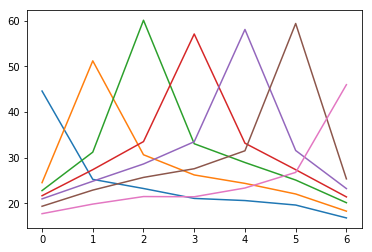

In [20]:
plt.plot(data_dict[run_time]);

# Set Up

In [21]:
s_x, s_xbar, s_y, s_ybar = sp.symbols('x,xbar,y,ybar')
a, a_x, a_y = sp.symbols('a,a_x,a_y')
a_bar, a_x_bar, a_y_bar = sp.symbols('abar,a_xbar,a_ybar')
s_length_scale, s_variance = sp.symbols('l,sigma')
kernel = s_variance*sp.exp(-((s_x-s_xbar)**2 + (s_y-s_ybar)**2) / (2.*s_length_scale**2))
symbols = [[s_x, s_y, a, a_x, a_y], [s_xbar, s_ybar, a_bar, a_x_bar, a_y_bar], [s_length_scale, s_variance]]

Use:
\begin{align*}
    \nabla \cdot (\exp(a)\nabla u) &= \nabla \exp(a) \cdot \nabla u + \exp(a) \nabla^2 u \\
    &= \exp(a) \left( \nabla a \cdot \nabla u + \nabla^2 u \right) \\
    &= \exp(a) \left( a_x u_x + a_y u_y + u_{xx} + u_{yy} \right)
\end{align*}
and:
\begin{align*}
    \exp(a) \nabla u \cdot n &= \exp(a) (x u_x + y u_y)
\end{align*}
for the special case of a unit circular domain centered at the origin.

## Set up Proposal Matrix

In [22]:
proposal_kernel = kernel
def diff_x(k):
    return k.diff(s_x)
def diff_y(k):
    return k.diff(s_y)
def diff_x_bar(k):
    return k.diff(s_xbar)
def diff_y_bar(k):
    return k.diff(s_ybar)

proposal_op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [diff_x, diff_y], 
    [diff_x_bar, diff_y_bar], 
    proposal_kernel,
    [[s_x, s_y], [s_xbar, s_ybar], [s_length_scale, s_variance]]
)

In [23]:
proposal_design = eit.grids.construct_shell(np.linspace(0,1,n_radii_inverse))

(1.05, -1.05)

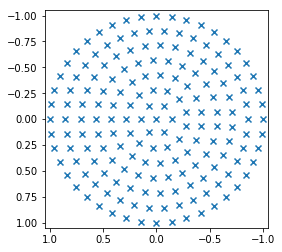

In [24]:

plt.figure(figsize=(4,4))
plt.scatter(proposal_design[:,0], proposal_design[:,1], marker='x')
plt.xlim(1.05,-1.05);plt.ylim(1.05,-1.05)

In [25]:
n_sensor = 8
n_bdy = 32

In [26]:
proposal_fun_args = np.array([conductivity_ls, conductivity_variance_mult])
proposal_cov = bpdes.collocation.compute_operator_matrix(
    [()],
    [()],
    [proposal_design],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)

proposal_cov_inv = np.linalg.inv(proposal_cov)
np.linalg.cond(proposal_cov)


5646664006.650932

In [27]:
fun_args = np.array([kernel_ls, kernel_variance_mult])

In [28]:
conductivity_field = 2.24*np.ones(proposal_cov.shape[1])

In [29]:
def augment_grid(grid, proposal_dot_mat, proposal):
    # transform the proposal
    transformed = np.dot(proposal_dot_mat, proposal)
    
    # break up into the constituent parts
    proposal_interior = transformed[:len(grid.interior)]
    proposal_bdy = transformed[len(grid.interior):len(grid.interior_plus_boundary)]
    proposal_sensors = transformed[len(grid.interior)+len(grid.boundary):len(grid.all)]
    proposal_interior_x = transformed[len(grid.all):len(grid.all)+len(grid.interior)]
    proposal_interior_y = transformed[len(grid.all)+len(grid.interior):len(grid.all)+2*len(grid.interior)]
    
    # construct new arrays
    new_interior = np.empty((len(grid.interior), 5))
    new_boundary = np.empty((len(grid.boundary), 5))
    new_sensors = np.empty((len(grid.sensors), 5))
    
    # add the data
    new_interior[:,:2] = grid.interior
    new_interior[:,2] = proposal_interior
    new_interior[:,3] = proposal_interior_x
    new_interior[:,4] = proposal_interior_y
    
    new_boundary[:,:2] = grid.boundary
    new_boundary[:,2] = proposal_bdy
    
    new_sensors[:,:2] = grid.sensors
    new_sensors[:,2] = proposal_sensors
    
    return eit.grids.EITGrid(new_interior, new_boundary, new_sensors)

In [30]:
shell_sizes = [4,5,6,7,8,9,10,11,12]
grid_sizes = []
matrix_conds = []
solve_errs = []
ldlt_solve_errs = []
mu_errs = []
cov_dets = []
for n_in_shell in shell_sizes:
    grid = eit.grids.construct_circular(n_in_shell, n_bdy, n_sensor)
    proposal_lhs_mat = bpdes.collocation.compute_operator_matrix(
        [(), diff_x, diff_y], 
        [()],
        [grid.all, grid.interior, grid.interior],
        [proposal_design],
        proposal_op_system,
        proposal_fun_args
    )
    proposal_dot_mat = np.linalg.solve(proposal_cov, proposal_lhs_mat.T).T
    
    proposal_grid = augment_grid(grid, proposal_dot_mat, conductivity_field)
    kern, left, central = eit.collocate.collocate_matrices_no_obs(
        np.asfortranarray(proposal_grid.sensors),
        np.asfortranarray(proposal_grid.interior),
        np.asfortranarray(proposal_grid.boundary),
        np.asfortranarray(proposal_grid.sensors),
        np.asfortranarray(fun_args)
    )
    
    mu_mult_c, cov_c, err = eit.collocate.collocate_no_obs(
        np.asfortranarray(proposal_grid.sensors),
        np.asfortranarray(proposal_grid.interior),
        np.asfortranarray(proposal_grid.boundary),
        np.asfortranarray(proposal_grid.sensors),
        np.asfortranarray(fun_args),
        "LDLT",
        report_solve_error=True
    )
    
    
    obs = np.zeros(len(grid.all))
    obs[-stim_pattern.shape[1]:] = stim_pattern[0,:]
    
    mu_mult_np = np.linalg.solve(central, left.T).T
    mu_np = np.dot(mu_mult_np, obs)
    mu_c = np.dot(mu_mult_c, obs)
    
    solver_norm_err = np.linalg.norm(mu_mult_np.dot(central) - left)
    
    grid_sizes.append(len(grid.all))
    matrix_conds.append(np.linalg.cond(central))
    solve_errs.append(solver_norm_err)
    ldlt_solve_errs.append(err)
    mu_errs.append(np.linalg.norm(mu_np - mu_c))
    cov_dets.append(np.linalg.det(cov_c))

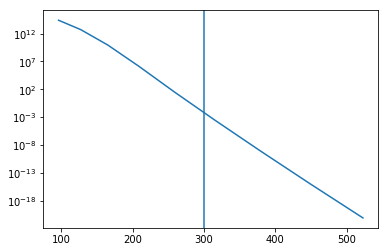

In [31]:
plt.semilogy(grid_sizes, cov_dets)
plt.axvline(300)

In [32]:
grid_sizes

[96, 127, 165, 209, 259, 316, 379, 448, 523]

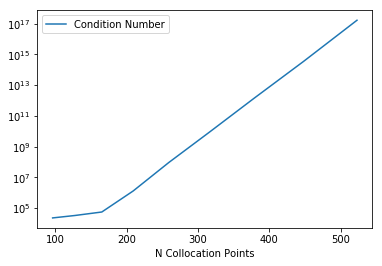

In [33]:
plt.semilogy(grid_sizes, matrix_conds, label='Condition Number')
plt.xlabel('N Collocation Points')
plt.legend()

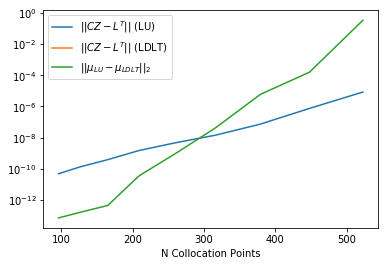

In [34]:
plt.semilogy(grid_sizes, solve_errs, label=r'$\|\| C Z - L^T \|\|$ (LU)')
plt.semilogy(grid_sizes, ldlt_solve_errs, label=r'$\|\| C Z - L^T \|\|$ (LDLT)')
plt.semilogy(grid_sizes, mu_errs, label=r'$\|\|\mu_{LU} - \mu_{LDLT}\|\|_2$')
plt.xlabel('N Collocation Points')
plt.legend()

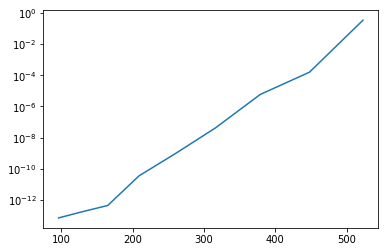

In [35]:
plt.semilogy(grid_sizes, mu_errs)

In [55]:
def optim_fun(ls):
    fun_args = np.array([ls, kernel_variance_mult], order='F')
    return -eit.collocate.log_likelihood(
        np.asfortranarray(grid.interior), 
        np.asfortranarray(grid.boundary), 
        np.asfortranarray(grid.sensors), 
        np.asfortranarray(conductivity_field), 
        np.asfortranarray(proposal_dot_mat),
        fun_args,
        np.asfortranarray(stim_pattern),
        np.asfortranarray(meas_pattern),
        np.asfortranarray(data_dict[11]),
        likelihood_variance
    )

In [56]:
shell_sizes = [4,5,6,7,8,9,10,11,12]
length_scales = []
for n_in_shell in shell_sizes:
    grid = eit.grids.construct_circular(n_in_shell, n_bdy, n_sensor)
    proposal_lhs_mat = bpdes.collocation.compute_operator_matrix(
        [(), diff_x, diff_y], 
        [()],
        [grid.all, grid.interior, grid.interior],
        [proposal_design],
        proposal_op_system,
        proposal_fun_args
    )
    proposal_dot_mat = np.linalg.solve(proposal_cov, proposal_lhs_mat.T).T
    
    
    obs = np.zeros(len(grid.all))
    obs[-stim_pattern.shape[1]:] = stim_pattern[0,:]
    
    res = scipy.optimize.minimize(lambda x: np.vectorize(optim_fun)(x), 0.1, method='Nelder-Mead')
    length_scales.append(res.x)

Text(0,0.5,'Optimum Length Scale')

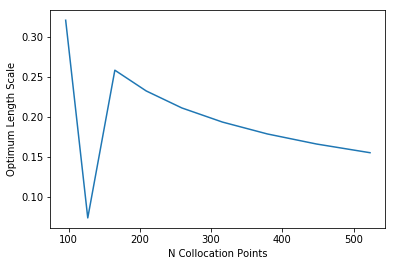

In [57]:
plt.plot(grid_sizes, length_scales)
plt.xlabel('N Collocation Points')
plt.ylabel('Optimum Length Scale')

In [38]:
import scipy.linalg

In [39]:
soln = np.linalg.solve(central, left.T)
mean = np.dot(soln.T, obs)
cov = kern - left.dot(soln)

In [40]:
print('Solution accuracy: ', np.linalg.norm(central.dot(soln) - left.T))
print('Cov det: ', np.linalg.det(cov))

Solution accuracy:  7.082353668749309e-06
Cov det:  8.380016039835719e-22


ValueError: z array must have same length as triangulation x and y arrays

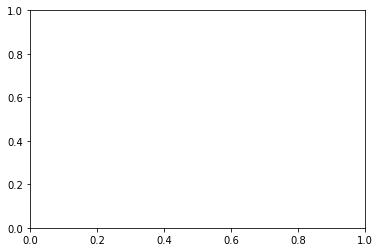

In [41]:
plt.tricontourf(proposal_design[:,0], proposal_design[:,1], mean, np.linspace(-80, 80, 30))
plt.gca().set_aspect('equal')
plt.colorbar()

In [ ]:
proposal_grid = augmented_grid(grid, np.ones(proposal_dot_mat.shape[1]))
kern_s, left_s, central_s = eit.collocate.collocate_matrices_no_obs(
    np.asfortranarray(grid.sensors),
    np.asfortranarray(proposal_grid.interior),
    np.asfortranarray(proposal_grid.boundary),
    np.asfortranarray(proposal_grid.sensors),
    np.asfortranarray(fun_args)
)

In [ ]:
soln_s = np.linalg.solve(central_s, left_s.T)
mu_s = np.dot(soln_s.T, obs)
cov_s = kern_s - np.dot(left_s, soln_s)
print('Sensor Cov det: ', np.linalg.det(cov_s))

In [ ]:
%%time
mu_mult_c, cov_c = eit.collocate.collocate_no_obs(
    np.asfortranarray(proposal_design), 
    np.asfortranarray(proposal_grid.interior), 
    np.asfortranarray(proposal_grid.boundary), 
    np.asfortranarray(proposal_grid.sensors),
    np.asfortranarray(fun_args),
    solver='LDLT'
)

In [ ]:
mu_c = np.dot(mu_mult_c, obs)

In [ ]:
plt.tricontourf(proposal_design[:,0], proposal_design[:,1], mu_c, np.linspace(-80, 80, 30))
plt.gca().set_aspect('equal')
plt.colorbar()

In [ ]:
mean - mu_c

In [ ]:
loaded_central = np.loadtxt('central.txt')
loaded_left = np.loadtxt('left.txt')

In [ ]:
loaded_soln = np.linalg.solve(loaded_central, loaded_left.T)

In [ ]:
np.linalg.norm(loaded_soln - soln)

In [ ]:
evals, evecs = np.linalg.eig(central)

In [ ]:
np.linalg.norm(left[0,:] - central.dot(np.linalg.solve(central, left[0,:])))

In [ ]:
np.linalg.det(cov)

In [ ]:
np.linalg.cond(central)